In [57]:
# %matplotlib widget

import numpy as np
import math
from matplotlib import pyplot as plt
import torch
import tifffile
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
from findpeaks import findpeaks
# from pathlib import Path
import glob
from model import BraggNN
from matplotlib.animation import FuncAnimation
import h5py

# BraggNN demonstration on simulated Bragg peak

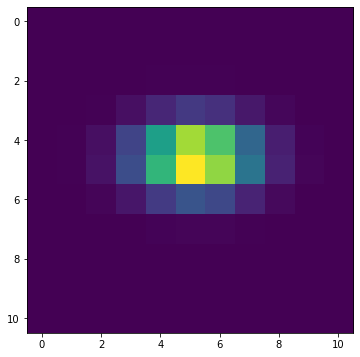

In [58]:
# load a pre-trained model that takes 11x11 patch as input
model  = BraggNN(imgsz=11, fcsz=(16, 8, 4, 2)) # should use the same argu as it in the training.
mdl_fn = 'models/fc16_8_4_2-sz11.pth'
model.load_state_dict(torch.load(mdl_fn, map_location=torch.device('cpu')))

#Generate 11x11 patch containing a Bragg peak and noise, with 100 SNR
X_test = np.zeros((11, 11)) + np.random.random((11,11))
x_cen, y_cen = 5.2, 4.6
sig_x, sig_y = 0.6, 1.5
for x in range(11):
    for y in range(11):
        X_test[y][x] = 100*(np.exp(-(x-x_cen)*(x-x_cen)/2*sig_x -(y-y_cen)*(y-y_cen)/2*sig_y))


# the input needs to be normalized to 0-1, e.g., rescale using min-max norm
X_test = (X_test - X_test.min()) / (X_test.max() - X_test.min())

plt.figure(figsize = (6,6))
plt.imshow(X_test)

(1, 1, 11, 11)
Peak was generated at (5.20, 4.60)
NN Peak location fit is (5.14, 4.57)
Fit error is 0.062 pixels


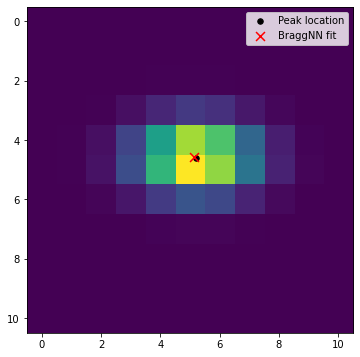

In [59]:
#Feed simulated patch to pre-trained CNN
print(X_test[np.newaxis, np.newaxis].shape)
input_tensor = torch.from_numpy(X_test[np.newaxis, np.newaxis].astype('float32'))
with torch.no_grad():
    pred = model.forward(input_tensor).cpu().numpy()
fit = pred * 11
print('Peak was generated at (%.2f, %.2f)' %(x_cen, y_cen))
print('NN Peak location fit is (%.2f, %.2f)' %(fit[0][0], fit[0][1]))
print('Fit error is %.3f pixels' %np.sqrt((x_cen-fit[0][0])**2 + (y_cen - fit[0][1])**2))

plt.figure(figsize = (6,6))
plt.imshow(X_test)
plt.scatter(x_cen, y_cen, color = 'k', s=30, label = 'Peak location')
plt.scatter(fit[0,0], fit[0,1], color='r', s=80, marker = 'x', label = 'BraggNN fit')
plt.legend()

# Code test on single detector image from our data
### Load and pre-process data

Text(0.5, 1.0, 'Binned and masked data')

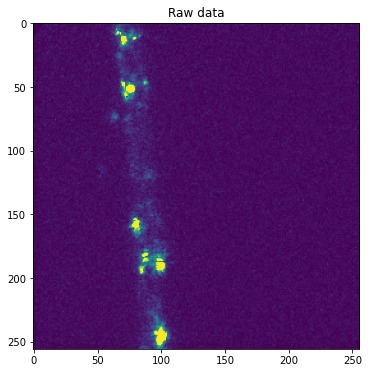

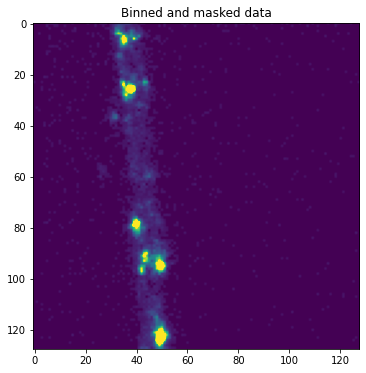

In [88]:
#Load and plot example detector image

image = tifffile.imread('../../data//CoinCell_120um_0.33C_good/p3/Shpyrko223a_S5143_00000.tif')
plt.figure(figsize = (6,6))
plt.title('Raw data')
plt.imshow(image, vmax = 100)

#Method to re-bin detector image to a new shape
def rebin(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

#Rebin and mask image
minval = 5
newshape = (128,128)
binned_image = rebin(image, newshape)
binned_image[binned_image<minval] = 0

plt.figure(figsize = (6,6))
plt.imshow(binned_image, vmax = 100)
plt.title('Binned and masked data')

### Use findpeaks() to estimate peak locations

[findpeaks] >Finding peaks in 2d-array using topology method..
[findpeaks] >Scaling image between [0-255] and to uint8
[findpeaks] >Conversion to gray image.
[findpeaks] >WARNING: Conversion to gray not possible.
[findpeaks] >Denoising with [fastnl], window: [3].
[findpeaks] >Detect peaks using topology method with limit at None.
[findpeaks] >Detect peaks using topology method with limit at None.
[findpeaks] >Fin.


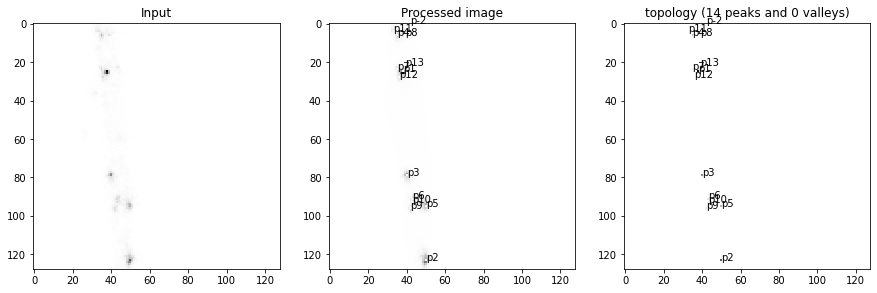

Located 9 peaks after filtering


In [89]:
def findPeaks(binned_image, minval = 5, minscore = 10, plot = False):
    '''Function that uses findpeaks module to roughly locate peaks in detector image
    
    Arguments:
    binned_image - 2D array w/ detector image
    minval - minimum value below which background is set to 0 (default 5)
    minscore - minimum peak persistence score to be included in results
    
    Returns:
    x, y - arrays of coordinates for peaks (Npeaks,2), dtype = int
    scores - array of persistence scores for each peak (Npeaks), dtype = int
    '''
    verbose = 1
    # Initialize
    if plot:
        verbose = 3
    fp = findpeaks(method='topology',verbose = verbose)
    #Mask off any values < minval
    mask = binned_image > minval
    X = binned_image * mask
    # Fit topology method on the image
    results = fp.fit(X)
    if plot:
        fp.plot()
    #Select only peaks from result, with score > minscore
    peak_mask = (results['persistence']['peak'].values) & (results['persistence']['score'].values > minscore)
    scores = results['persistence']['score'][peak_mask]
    x = results['persistence']['x'][peak_mask]
    y = results['persistence']['y'][peak_mask]
    if plot:
        print('Located %i peaks after filtering' %len(scores))
    return x, y, scores

x, y, scores = findPeaks(binned_image, plot=True)

### Overlay filtered rough peak locations from findpeaks() on input data

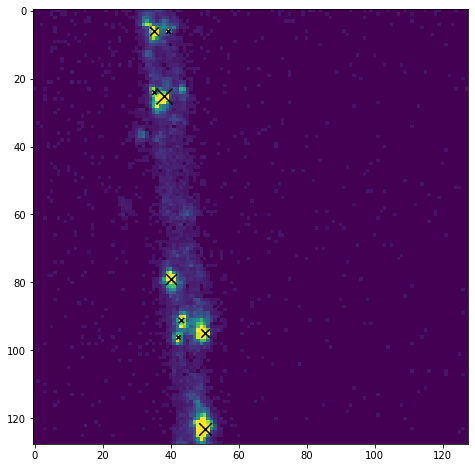

In [97]:
plt.figure(figsize = (8,8))
plt.imshow(binned_image, vmax = 100)
for i in range(len(scores)):
    plt.scatter(x[i], y[i], color = 'k', marker = 'x', s = scores[i], alpha = 1)


[[37.88563251 25.38623714]
 [39.89793253 78.61728239]
 [35.17840862  6.20455265]
 [49.63938236 94.40812969]
 [42.94512892 90.8866806 ]]


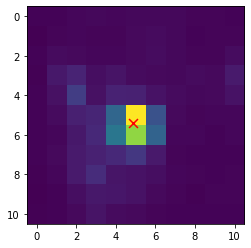

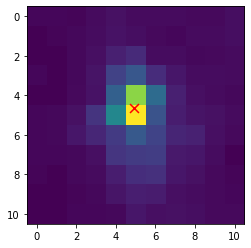

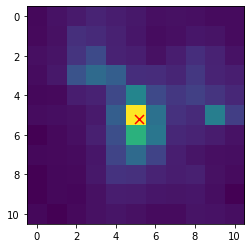

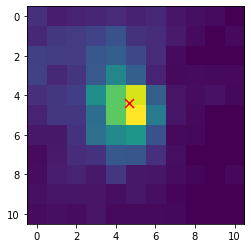

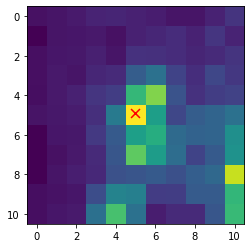

In [90]:
def runBraggNN(binned_image, x, y, scores, plot = True):
    '''Function that takes an entire binned detector image and approximate [x,y] coordinates
        of peaks within that image, and creates 11x11 patches and runs BragNN to determine precise peak location
        
    Arguments:
    binned_image - 2D array w/ detector image
    x, y - arrays of coordinates for peaks
    plot - whether to plot individual patches and fitted peak locations
    
    Returns:
    NN_fit - array of precise peak coordinates

    '''
    NN_fit = []
    scores_filtered = []
    x_filt, y_filt = [],[]
    for i in range(len(x)):
        x_c, y_c = x[i], y[i]
        try:
            #Define and normalize patch
            patch = binned_image[y_c-5:y_c+6 , x_c-5:x_c+6]
            patch = (patch - patch.min()) / (patch.max()-patch.min())

            #Check that max value within patch is roughly in the center
            x_max, y_max = np.unravel_index(patch.argmax(), patch.shape)

            if (x_max > 3) & (x_max < 7) & (y_max > 3) & (y_max < 7):
                #Run BragNN on patch
                input_tensor = torch.from_numpy(patch[np.newaxis, np.newaxis].astype('float32'))
                with torch.no_grad():
                    pred = model.forward(input_tensor).cpu().numpy()
                pred = pred * 11
                if plot:
                    plt.figure()
                    plt.imshow(patch)
                    plt.scatter(*pred[0], color='r', marker = 'x', s = 80)
                NN_fit.append(pred[0] + [x_c-5, y_c-5])
                scores_filtered.append(scores[i])
                x_filt.append(x_c)
                y_filt.append(y_c)
        except:
#             print('Unable to generate/fit patch')
            continue
    return np.array(NN_fit), x_filt, y_filt, scores_filtered


NN_fit, x_filt, y_filt, scores_filtered = runBraggNN(binned_image, x, y,scores, plot = True)
print(NN_fit)

### Overlay  precise peak locations from BraggNN on input data

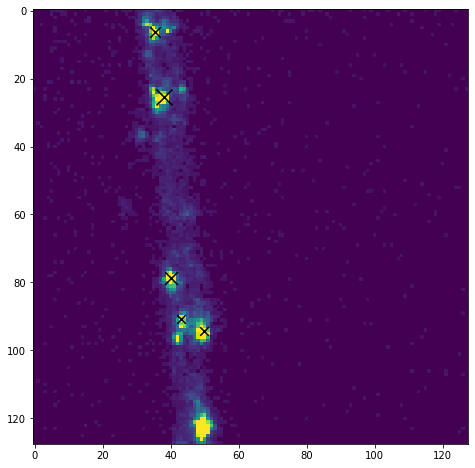

In [96]:
plt.figure(figsize = (8,8))
plt.imshow(binned_image, vmax = 100)
for i in range(len(scores_filtered)):
    plt.scatter(NN_fit[i][0], NN_fit[i][1], color = 'black', marker = 'x', s = scores[i], alpha = 1)


# 2D Gaussian least-square fit for establishing "ground truth"
### Fitting

In [75]:
import lmfit

def get_peak_locations(binned_image, x, y):
    fit = []
    for i in range(len(x)):
        x_c, y_c = x[i], y[i]
        try:
            #Define and normalize patch
            patch = binned_image[y_c-5:y_c+6 , x_c-5:x_c+6]
            patch = (patch - patch.min()) / (patch.max()-patch.min())
            
            #Check that max value within patch is roughly in the center
            x_max, y_max = np.unravel_index(patch.argmax(), patch.shape)
            if (x_max > 3) & (x_max < 7) & (y_max > 3) & (y_max < 7):
                x_fit, y_fit = get_peak_location_2d(patch)[0] + x_c - 5, get_peak_location_2d(patch)[1] + y_c -5
                fit.append([x_fit, y_fit])
            
        except ValueError:
            continue
#             print('Unable to generate/fit patch')
    return np.array(fit)

def get_peak_location_2d(image):
    

    # Set initial parameters for the Gaussian2d model
    '''
    params = gaussian2d.make_params()
    params['amplitude'].set(value=np.max(image), min=0)
    params['centerx'].set(value=image.shape[1]/2, min=0, max=image.shape[1])
    params['sigmax'].set(value=1, min=0)
    params['centery'].set(value=image.shape[0]/2, min=0, max=image.shape[0])
    params['sigmay'].set(value=1, min=0)
    '''

    img_flattened = image.ravel()
    x = np.linspace(0, 10, 11)
    y = np.linspace(0, 10, 11)
    Xg, Yg = np.meshgrid(x, y)
    Z = image
    model = lmfit.models.Gaussian2dModel()
    params = model.guess(Z.flatten(), Xg.flatten(), Yg.flatten())  # method cannot deal with 2D data
    result = model.fit(Z, x=Xg, y=Yg, params=params)
        
    # Return the location of the peak
    x = result.params['centerx'].value
    y = result.params['centery'].value
    return [x, y]

Gauss_fit = get_peak_locations(binned_image, x, y)
print(Gauss_fit)

[[40.0472721  78.95383936]
 [38.00573731 24.99542286]
 [48.91108459 93.51238652]
 [35.1705251   5.47692001]]


### Comparing BraggNN and Gaussian fits

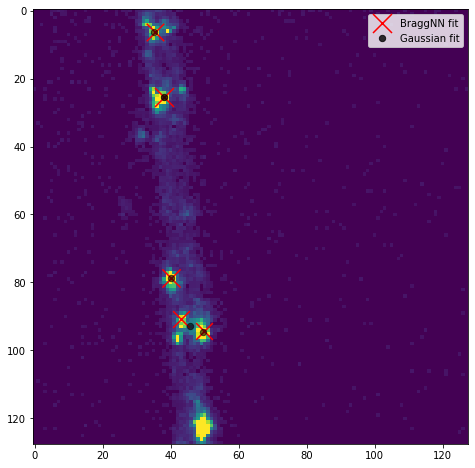

In [71]:
#Entire detector image
plt.figure(figsize = (8,8))
plt.imshow(binned_image, vmax = 100)
for i in range(len(scores_filtered)):
    #Create just 1 legend
    if i==0:
        plt.scatter(NN_fit[i][0], NN_fit[i][1], color = 'red', marker = 'x', s = np.log10(scores[i]) * 150, label = 'BraggNN fit')
        plt.scatter(Gauss_fit[i][0], Gauss_fit[i][1], color = 'k', s = 40, alpha = 0.8, label = 'Gaussian fit')
    else:
        plt.scatter(NN_fit[i][0], NN_fit[i][1], color = 'red', marker = 'x', s = np.log10(scores[i]) * 150)
        plt.scatter(Gauss_fit[i][0], Gauss_fit[i][1], color = 'k', s = 40, alpha = 0.6)        
plt.legend()

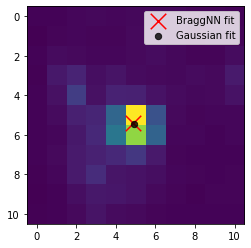

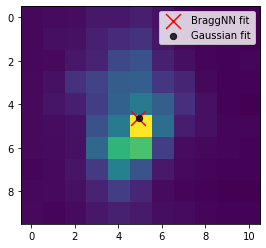

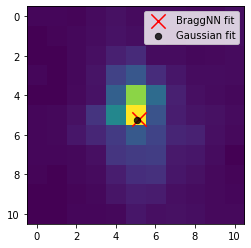

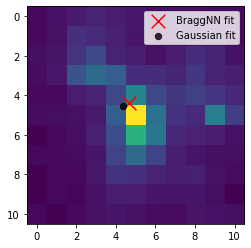

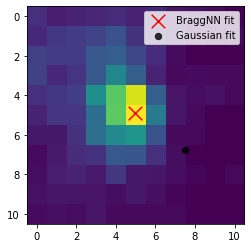

In [72]:
#individual patches
for i in range(len(scores_filtered)):
    patch = binned_image[y[i]-5:y[i]+6 , x[i]-5:x[i]+6]
    patch = (patch - patch.min()) / (patch.max()-patch.min())
    plt.figure()
    plt.imshow(patch)
    plt.scatter(NN_fit[i][0] - x_filt[i] + 5, NN_fit[i][1] - y_filt[i] + 5, color = 'red', marker = 'x', s = np.log10(scores[i]) * 100, label = 'BraggNN fit')
    plt.scatter(Gauss_fit[i][0] - x_filt[i] + 5, Gauss_fit[i][1] - y_filt[i] + 5, color = 'black', s = 40, alpha = 0.8, label = 'Gaussian fit')
    plt.legend()

# Running pipeline on entire dataset

In [85]:
directory = '/home/bstoyche/teams/group-6/data/CoinCell_120um_0.33C_good/p3/'
pathlist = sorted(glob.glob(directory +'*.tif'))
N_images = len(pathlist)
print('Total number of frames in dataset: ',N_images)
NN_fit_arr = []
score_arr = []
fit_arr = []
binning = (128, 128)

for i, path in enumerate(pathlist):
    if i%20==0:
        print('Frame ',i)
    #Load and rebin detector image
    image = tifffile.imread(path)
    binned_image = rebin(image, binning)
    x, y, scores = findPeaks(binned_image, minval = 10, minscore = 10)  # vary minval, minscore

    NN_fit, _, _, scores_filtered = runBraggNN(binned_image, x, y,scores, plot = False)
    NN_fit_arr.append(NN_fit)
    score_arr.append(scores_filtered)
    fit = get_peak_locations(binned_image, x, y)
    fit_arr.append(fit)
NN_fit_arr = np.array(NN_fit_arr)
fit_arr = np.array(fit_arr)
NN_fit_arr = np.array(NN_fit_arr)
print(NN_fit_arr.shape)

Total number of frames in dataset:  481
Frame  0
Frame  20
Frame  40
Frame  60
Frame  80
Frame  100
Frame  120
Frame  140
Frame  160
Frame  180
Frame  200
Frame  220
Frame  240
Frame  260
Frame  280
Frame  300
Frame  320
Frame  340
Frame  360
Frame  380
Frame  400
Frame  420
Frame  440
Frame  460
Frame  480
(481,)


### Generate error plot

480


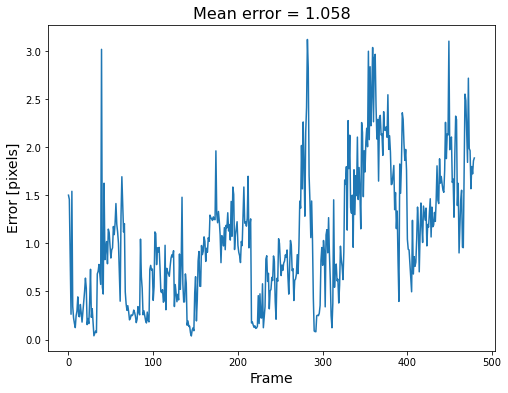

In [100]:
MAX_DIST = 10
errors = []
for i in range(len(fit_arr)):
    error = 0
    length = 0
    for j in range(len(fit_arr[i])):
        try:
            if not (fit_arr[i][j][0]<0 or fit_arr[i][j][1]<0): # calculate error only when get_peak_locations() is functioning normally
                dist = math.dist(fit_arr[i][j],NN_fit_arr[i][j])
                if dist <= MAX_DIST:
                    error += dist
                else:
                    length -= 1
                length += 1
        except IndexError:
            pass
    if length == 0:
        errors.append(np.nan)
    else:
        errors.append(error/length)
print(np.argmax(errors))
plt.figure(figsize = (8,6))
plt.xlabel('Frame', fontsize = 14)
plt.ylabel('Error [pixels]', fontsize = 14)
plt.savefig('error_')
plt.title('Mean error = %.3f' %np.nanmean(errors), fontsize = 16)
plt.plot(errors)
plt.show()


### Create animation of results

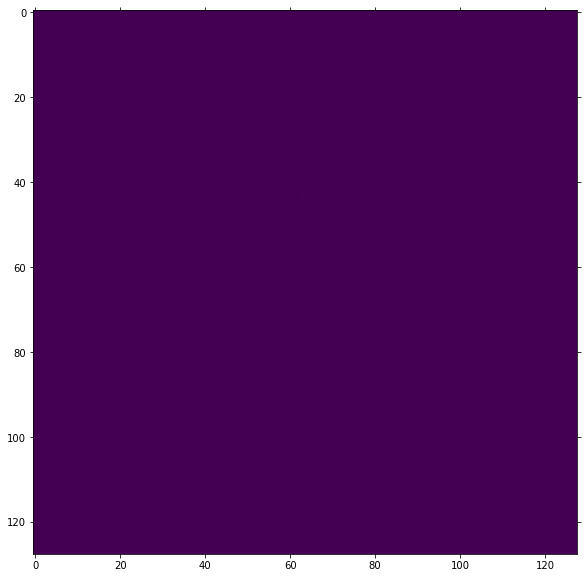

In [101]:
#Create animation of results
def animation_function(i):
    plt.cla()
    image = tifffile.imread(sorted(pathlist)[i])
    binned_image = rebin(image, binning)
    
    plt.imshow(binned_image, vmax = 50)
    try:
        plt.scatter(NN_fit_arr[i][:,0], NN_fit_arr[i][:,1], color = 'k', marker = 'x', s = score_arr[i])
    except IndexError:
        pass
    
fig = plt.figure(figsize = (10,10))
animation = FuncAnimation(fig, animation_function,
                          frames = len(pathlist), interval = 100)
animation.save('results.gif')
plt.show()

# Attempts to Re-train BraggNN
### Re-formatting our data to hdf5 as required by BraggNN

In [111]:
'''
peaks.hdf5 file needs to have datasets with keys ['peak_row'], ['peak_col'] and ['peak_fidx'] as described on BraggNN GitHub
'''
fit_x = []
fit_y = []
framenum = []

for i in range(len(fit_arr)):
    for j in range(len(fit_arr[i])):
        if len(fit_arr[i])==0:
            print('length=0')
        fit_x.append(fit_arr[i][j][0])
        fit_y.append(fit_arr[i][j][1])
        framenum.append(i)
        
# #Randomly permute peaks in consistent way
# perm = np.random.permutation(len(fit_x))
# framenum = framenum[perm]
# fit_x = fit_x[perm]
# fit_y = fit_y[perm]

try:
    peakfile = h5py.File('peaks.hdf5','a')
    peakfile.create_dataset('peak_row', data = fit_y)
    peakfile.create_dataset('peak_col', data = fit_x)
    peakfile.create_dataset('peak_fidx', data = framenum)
    peakfile.close()
except ValueError:
    print('File already exists!')
data = []
for i, path in enumerate(sorted(pathlist)):
    image = tifffile.imread(path)
    binned_image = rebin(image, binning)
    data.append(binned_image)
    
data = np.array(data)
try:
    framefile = h5py.File('frames_c0.1.hdf5','a')
    framefile.create_dataset('frames', data = data)
    framefile.close()
except ValueError:
    print('File already exists!')

File already exists!
File already exists!
